# Getting Started With OpenAI's Toolkit: gym

From gym's [documentation](https://gym.openai.com/docs/):

> Gym is a toolkit for developing and comparing reinforcement learning algorithms.
> The gym library is a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.


Let's start by importing some libraries.

In [7]:
import gym
import scipy
import numpy as np

## Loading CartPole

Next we'll load one of the environments included in the gym toolkit. This environment is called [CartPole](https://gym.openai.com/envs/CartPole-v1/).

In [8]:
env = gym.make("CartPole-v1")

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


Now that we have an environment, 'env', let's see what it looks like.

In [9]:
env.render()

Right now it just a white screen. This is because the render() function only shows one frame, the current state of the environment. Usually we call it in a loop after the environment state has changed.

To close the rendered window we can use env.close()

In [10]:
env.close()

## Examine Test Program

Now, let's look at the program we used to test our environment, cartpole-test.py

The full program is copied in the code block below. Go ahead and run it.

In [56]:
import gym
import scipy
import numpy as np

env = gym.make("CartPole-v1")

for episode in range(10):
    observation = env.reset()  # Observe the environment
    totalreward = 0
    for _ in range(200):
        env.render()
        action = env.action_space.sample()  # Decide how to act
        observation, reward, done, info = env.step(action) # Act accordingly
        totalreward += reward  # Receive reward/penalty
        if done:
            break
    print("Reward for Episode {}: {}".format(episode, totalreward))
    
env.close()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Reward for Episode 0: 25.0
Reward for Episode 1: 15.0
Reward for Episode 2: 14.0
Reward for Episode 3: 20.0
Reward for Episode 4: 27.0
Reward for Episode 5: 15.0
Reward for Episode 6: 17.0
Reward for Episode 7: 31.0
Reward for Episode 8: 9.0
Reward for Episode 9: 18.0


This program is a basic template for using the gym interface.

Note that it follows most of the steps of the learning process for reinforcement learning:
1. Observation of the environment
2. Deciding how to act (Stategy in this example is randomly choosing)
3. Acting accordingly
4. Receiving a reward or penalty
5. ~~Learning from experiences and refining strategy~~
6. ~~Iterate until optimal strategy is found~~

Only step 5 and 6 are missing. We'll address that soon.

First we will examine steps 1-4.

## Observation, Action, Reward

In CartPole's environment, there are four observations at any given state, representing information such as the angle of the pole and the position of the cart.

Using these observations, the agent needs to decide on one of two possible actions: move the cart left or right.

Let's get a better idea of how observations and actions are represented in the environment.

In [29]:
print(env.observation_space)
observation = env.reset()  # Observe the environment
print(observation)

Box(4L,)
[-0.02928487  0.00730412 -0.01417011  0.04018474]


So the Agent in the CartPole example "sees" the environment solely as these four continous values.

In [32]:
print(env.action_space)
action = env.action_space.sample()  # Decide how to act
print(action)

Discrete(2)
0


And the Agent can take two actions: 0 or 1 (move left or move right).

## Solving Without Reinforcement Learning

This makes for a relatively simple environment for reinforcement learning. Let's start with something more basic.

A simple way to map these observations to an action choice is a linear combination. We define a vector of weights, each weight corresponding to one of the observations. Start off by initializing them randomly between [-1, 1].

In [33]:
parameters = np.random.rand(4) * 2 - 1  

How is the weight vector used? Each weight is multiplied by its respective observation, and the products are summed up. This is equivalent to performing an inner product (matrix multiplication) of the two vectors. If the total is less than 0, we move left. Otherwise, we move right. This is similar to linear regression or a neural network with no hidden layers.

In [35]:
action = 0 if np.matmul(parameters,observation) < 0 else 1

# Or expressed as:
if np.matmul(parameters,observation) < 0:
    action = 0
else:
    action = 1

Now we have a basic model for choosing actions based on the observations.

Next we will want to know how well we're doing. For every timestep we keep the pole straight, we get +1 reward. To estimate how good a given set of weights is, we can just run an episode until the pole drops and see how much reward we got.

Let's write a function that can run one episode and report the reward. We'll consider an episode solved if it lasts for 200 timesteps.

In [45]:
def run_episode(env, parameters):  
    observation = env.reset()
    goal = 200
    totalreward = 0
    for _ in range(goal):
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

In [49]:
env = gym.make("CartPole-v1")  # Setup fresh environment
parameters = np.random.rand(4) * 2 - 1  # Initialize parameters

run_episode(env, parameters)  # Run Episode

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


10.0

**Note: The highest reward possible in one episode is 200.**

Now we can measure how well our model performs. The problem to solve is: how can we select the parameters that achieve the highest amount of average reward?

### Random Search

A straightforward strategy is to keep trying random weights then picking the one that peforms the best.

In [70]:
def random_search():
    num_episodes = 10000
    bestparams = None
    bestreward = 0
    for episodes in range(1, num_episodes+1):  # run 10,000 episodes
        parameters = np.random.rand(4) * 2 - 1
        reward = run_episode(env, parameters)
        if reward > bestreward:  # Check for new personal best
            bestreward = reward
            bestparams = parameters  # Remember winning parameters
            # considered solved if the agent lasts 200 timesteps
            if reward == 200:
                break
    return episodes

In [74]:
count = random_search()
print("Solved in {} episodes".format(count))

Solved in 6 episodes


### Hill-Climbing

Another method of choosing parameter weights is the hill-climbing algorithm. We start with some randomly chosen initial weights. Every episode, add some noise to the weights, and keep the new weights if the agent improves.

In [75]:
def hill_climb():
    num_episodes = 10000
    noise_scaling = 0.1
    bestparams = None
    bestreward = 0
    parameters = np.random.rand(4) * 2 - 1
    for episodes in range(1, num_episodes+1):  # run 10,000 episodes
        parameters = parameters + (np.random.rand(4) * 2 - 1) * noise_scaling
        reward = run_episode(env, parameters)
        if reward > bestreward:  # Check for new personal best
            bestreward = reward
            bestparams = parameters  # Remember winning parameters
            # considered solved if the agent lasts 200 timesteps
            if reward == 200:
                break
    return episodes

In [81]:
count = hill_climb()
print("Solved in {} episodes".format(count))

Solved in 2073 episodes


### Better Evaluation

It appears that the random search strategy typically solves the problem in less than 100 episodes. Does the Hill Climb strategy do better or worse?

One way to tell is to plot a histogram of how many episodes it took to solve over man trials.

In [82]:
import matplotlib.pyplot as plt

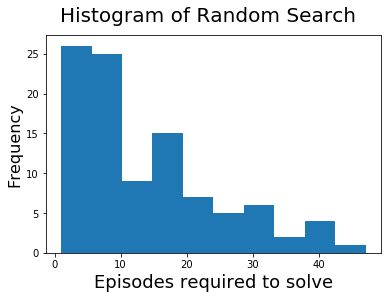

In [87]:
episodes_list = []
for step in range(100):                   # Run random_search() 1000 times
    episodes_list.append(random_search())  # Storing results in episodes_list

fig = plt.figure()
plt.hist(episodes_list)
fig.suptitle('Histogram of Random Search', fontsize=20)
plt.xlabel('Episodes required to solve', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In [ ]:
episodes_list = []
for step in range(100):                 # Run random_search() 1000 times
    episodes_list.append(hill_climb())  # Storing results in episodes_list

fig = plt.figure()
plt.hist(episodes_list)
fig.suptitle('Histogram of Hill-Climbing Search', fontsize=20)
plt.xlabel('Episodes required to solve', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

Since the CartPole environment is relatively simple, with only 4 observations, this basic method works surprisingly well. In most cases a more guided strategy like Hill-Climbing does better than random search. It's always good to start with the most simple strategy to use as a benchmark.